In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import requests
from pprint import pprint
import math

# machine learning libraries
from keras.models import Sequential, Model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler  

# visualisation
import matplotlib.pyplot as plt
from plot_keras_history import plot_history

In [99]:
base_url = 'https://fantasy.premierleague.com/api/'

r = requests.get(base_url+'bootstrap-static/').json()
# print(r)
pprint(r, indent=2, depth=1, compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 10928227}


In [100]:
players = pd.json_normalize(r['elements'])

In [101]:
players.head(20)

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90
0,100.0,100.0,58822,0,0,-3,3,0,2,0.5,...,544,157,105,62,376,141,401,147,0.00000,0.00000
1,NaN,NaN,84450,0,0,1,-1,1,3,0.5,...,171,99,489,183,42,20,83,28,1.08062,0.46312
2,100.0,100.0,153256,0,0,-3,3,1,3,0.5,...,551,284,112,3,343,150,210,69,0.95745,0.00000
3,NaN,NaN,156074,0,0,-3,3,0,2,0.5,...,552,163,113,68,379,144,419,155,0.00000,0.00000
4,100.0,100.0,167199,0,0,-2,2,0,3,0.5,...,260,157,406,129,73,35,245,80,1.03233,0.65693
5,100.0,100.0,184029,0,0,-1,1,3,3,0.5,...,57,27,610,260,10,5,25,11,1.08736,0.50186
6,100.0,100.0,192895,0,0,-3,3,0,2,0.5,...,298,51,379,188,316,113,204,72,0.78261,0.26087
7,0.0,0.0,195735,0,0,-2,2,0,3,0.0,...,147,83,524,210,657,282,422,155,0.00000,0.00000
8,NaN,NaN,198869,1,-1,2,-2,0,2,0.5,...,299,52,380,189,31,7,39,12,1.09565,0.62609
9,NaN,NaN,205533,0,0,-5,5,0,4,0.5,...,55,26,614,53,450,57,252,41,0.00000,0.00000


In [102]:
players.columns
# potential features
# y:points x:ppg, team_code, id, element_type, now_cost, form, chance of playing, opp_teams
# additional x: previous weeks goals/points/assists/saves
# players will give us current data (data to predict), history will give us training data
# use these features first for a base model, then we can build a model for each position
len(players)

667

In [103]:
teams = pd.json_normalize(r['teams'])
teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,...,None,False,0,1220,1270,1240,1250,1200,1270,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,...,None,False,0,1090,1100,1110,1130,1090,1110,2
2,91,0,None,3,0,Bournemouth,0,0,0,BOU,...,None,False,0,1060,1090,1070,1130,1050,1080,127
3,94,0,None,4,0,Brentford,0,0,0,BRE,...,None,False,0,1100,1130,1100,1110,1130,1160,130
4,36,0,None,5,0,Brighton,0,0,0,BHA,...,None,False,0,1150,1160,1140,1160,1170,1190,131


In [104]:
fix_url = "https://fantasy.premierleague.com/api/fixtures/"
r = requests.get(fix_url).json()
games = pd.json_normalize(r)
# games.sample(20)
games = games[games['finished'] == True]

In [105]:
games.head()

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
11,2292810,1.0,True,True,1,2022-08-05T19:00:00Z,90,False,True,1,2.0,7,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,3,74911
12,2292813,1.0,True,True,4,2022-08-06T11:30:00Z,90,False,True,12,2.0,9,2.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,2,74914
13,2292811,1.0,True,True,2,2022-08-06T14:00:00Z,90,False,True,2,0.0,3,2.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,2,74912
14,2292814,1.0,True,True,5,2022-08-06T14:00:00Z,90,False,True,20,1.0,11,2.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,74915
15,2292816,1.0,True,True,7,2022-08-06T14:00:00Z,90,False,True,16,0.0,15,2.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,3,74917


In [106]:
standings = teams[['id', 'name']]
standings['points'] = 0
standings['goals'] = 0
standings['allowed'] = 0
standings['played']= 0

C:\Users\lucas\AppData\Local\Temp\ipykernel_18808\3440666143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings['points'] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_18808\3440666143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings['goals'] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_18808\3440666143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [111]:
def f(agg, a, h, a_score, h_score):
    if agg == 0:
        standings.loc[standings['id'] == a, 'points'] += 1
        standings.loc[standings['id'] == h, 'points'] += 1
    elif agg > 0:
        standings.loc[standings['id'] == a, 'points'] += 3
    else:
        standings.loc[standings['id'] == h, 'points'] += 3
    
    standings.loc[standings['id'] == a, 'goals'] += a_score
    standings.loc[standings['id'] == h, 'goals'] += h_score
    standings.loc[standings['id'] == a, 'allowed'] += h_score
    standings.loc[standings['id'] == h, 'allowed'] += a_score
    standings.loc[standings['id'] == a, 'played'] += 1
    standings.loc[standings['id'] == h, 'played'] += 1
    

In [112]:
# calculate points first 
games['agg_score'] = games['team_a_score'] - games['team_h_score']
games.apply(lambda r: f(r['agg_score'], r['team_a'], r['team_h'], r['team_a_score'], r['team_h_score']), axis=1)

11     None
12     None
13     None
14     None
15     None
       ... 
152    None
153    None
154    None
155    None
156    None
Length: 146, dtype: object

In [43]:
standings['goal_diff'] = standings['goals'] - standings['allowed']
standings = standings.sort_values(by=['points', 'goal_diff', 'goals', 'allowed'], ascending=False)
standings = standings.reset_index(drop=True)
standings['new_team_id'] = standings.index
standings['new_team_id'] += 1

C:\Users\lucas\AppData\Local\Temp\ipykernel_18808\2342003323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings['goal_diff'] = standings['goals'] - standings['allowed']


In [44]:
standings

,id,name,points,goals,allowed,played,goal_diff,new_team_id
0,1,Arsenal,37,33,11,14,22,1
1,13,Man City,32,40,14,14,26,2
2,15,Newcastle,30,29,11,15,18,3
3,18,Spurs,29,31,21,15,10,4
4,14,Man Utd,26,20,20,14,0,5
5,12,Liverpool,22,28,17,14,11,6
6,5,Brighton,21,23,19,14,4,7
7,6,Chelsea,21,17,17,14,0,8
8,9,Fulham,19,24,26,15,-2,9
9,4,Brentford,19,23,25,15,-2,10


In [45]:
# combine new_id with old team id 
teams = teams.merge(right=standings[['id', 'new_team_id']], on='id', how='left')
teams

,code,draw,form,id,loss,name,played,points,position,short_name,...,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id,new_team_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,...,False,0,1220,1270,1240,1250,1200,1270,1,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,...,False,0,1090,1100,1110,1130,1090,1110,2,12
2,91,0,None,3,0,Bournemouth,0,0,0,BOU,...,False,0,1060,1090,1070,1130,1050,1080,127,14
3,94,0,None,4,0,Brentford,0,0,0,BRE,...,False,0,1100,1130,1100,1110,1130,1160,130,10
4,36,0,None,5,0,Brighton,0,0,0,BHA,...,False,0,1150,1160,1140,1160,1170,1190,131,7
5,8,0,None,6,0,Chelsea,0,0,0,CHE,...,False,0,1200,1220,1200,1210,1180,1210,4,8
6,31,0,None,7,0,Crystal Palace,0,0,0,CRY,...,False,0,1100,1140,1100,1170,1080,1140,6,11
7,11,0,None,8,0,Everton,0,0,0,EVE,...,False,0,1080,1100,1080,1080,1080,1080,7,17
8,54,0,None,9,0,Fulham,0,0,0,FUL,...,False,0,1075,1100,1070,1070,1100,1130,34,9
9,13,0,None,10,0,Leicester,0,0,0,LEI,...,False,0,1130,1130,1080,1160,1180,1120,26,13


In [46]:
teams.columns

Index(['code', 'draw', 'form', 'id', 'loss', 'name', 'played', 'points',
       'position', 'short_name', 'strength', 'team_division', 'unavailable',
       'win', 'strength_overall_home', 'strength_overall_away',
       'strength_attack_home', 'strength_attack_away', 'strength_defence_home',
       'strength_defence_away', 'pulse_id', 'new_team_id'],
      dtype='object')

In [47]:
players[['web_name','now_cost','points_per_game', 'chance_of_playing_this_round']].head()

,web_name,now_cost,points_per_game,chance_of_playing_this_round
0,Cédric,42,1.0,100.0
1,Xhaka,51,4.4,NaN
2,Elneny,42,1.3,100.0
3,Holding,42,1.0,NaN
4,Partey,48,3.8,100.0


In [48]:
# to get the list of players playing
available_players = players[players['points_per_game'] != '0.0']

In [49]:
# y is total_points (goals_scored, assists, clean_sheets, goals_conceded)
hist_cols = ['element', 'minutes', 'opponent_team', 'total_points', 'was_home','influence', 'creativity', 'threat', 'ict_index', 'value']

In [64]:
element_id = '283'
player_ep = f'element-summary/{element_id}/'
r = requests.get(base_url+player_ep).json()
hist = pd.json_normalize(r['history'])[hist_cols]
hist

,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value
0,283,90,9,12,False,39.6,20.0,25.0,8.5,130
1,283,90,7,2,True,18.6,89.7,38.0,14.6,130
2,283,90,14,8,False,44.0,45.1,67.0,15.6,130
3,283,90,3,3,True,2.4,28.1,52.0,8.3,130
4,283,90,15,10,True,44.0,64.3,39.0,14.7,130
5,283,90,8,3,False,14.6,37.3,41.0,9.3,130
6,283,90,5,5,True,18.4,13.1,69.0,10.1,128
7,283,68,1,2,False,1.8,12.0,4.0,1.8,127
8,283,89,13,8,True,30.4,5.7,23.0,5.9,127
9,283,90,19,3,True,5.4,14.3,73.0,9.3,127


In [57]:
available_players.sample(20)

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90
597,NaN,NaN,45034,0,0,0,0,1,2,0.5,...,104,11,550,223,139,45,15,5,0.97944,0.32648
435,NaN,NaN,211975,0,0,0,0,0,2,1.0,...,198,27,479,215,76,17,156,54,1.02710,0.38516
532,NaN,NaN,109322,0,0,-6,6,0,3,-0.5,...,125,67,539,218,246,101,148,50,1.11663,0.55831
59,100.0,100.0,151589,0,0,-3,3,0,3,-1.0,...,291,179,372,109,315,136,451,170,0.88583,0.35433
271,NaN,NaN,76357,0,0,-3,3,0,3,0.0,...,284,174,365,104,346,153,506,197,0.27108,0.00000
319,100.0,100.0,172780,0,0,2,-2,1,3,0.0,...,15,7,653,280,12,6,38,13,1.06557,0.32787
242,100.0,100.0,121599,0,0,-2,2,0,3,0.0,...,142,78,519,205,367,162,470,181,0.98901,0.00000
170,75.0,0.0,109745,0,0,0,0,0,1,0.4,...,335,19,264,53,29,2,113,19,1.09091,0.54545
28,NaN,NaN,499175,0,0,0,0,0,3,0.5,...,406,222,335,85,417,183,623,253,0.00000,0.00000
55,100.0,100.0,433979,0,0,-3,3,0,4,-1.0,...,564,77,125,3,380,50,98,12,0.00000,0.00000


In [58]:
history = []
for i in available_players['id']:
    element_id = i
    player_ep = f'element-summary/{element_id}/'
    r = requests.get(base_url+player_ep).json()
    hist = pd.json_normalize(r['history'])[hist_cols]
    hist['played_ratio'] = len(hist[hist['minutes'] > 0]) / len(hist)
    history.append(hist)

history = pd.concat(history)
    

In [59]:
player_cols = ['id', 'first_name', 'second_name', 'web_name', 'team', 'team_code', 'element_type', 
               'influence', 'creativity', 'threat', 'ict_index']

In [60]:
av_players = available_players[player_cols]

In [67]:
av_players[av_players['web_name'] == 'Salah']

,id,first_name,second_name,web_name,team,team_code,element_type,influence,creativity,threat,ict_index
380,283,Mohamed,Salah,Salah,12,14,3,345.2,364.2,720.0,143.1


In [68]:
# current influence is the total of all games played
history[history['element'] == 283]

,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio
0,283,90,9,12,False,39.6,20.0,25.0,8.5,130,1.0
1,283,90,7,2,True,18.6,89.7,38.0,14.6,130,1.0
2,283,90,14,8,False,44.0,45.1,67.0,15.6,130,1.0
3,283,90,3,3,True,2.4,28.1,52.0,8.3,130,1.0
4,283,90,15,10,True,44.0,64.3,39.0,14.7,130,1.0
5,283,90,8,3,False,14.6,37.3,41.0,9.3,130,1.0
6,283,90,5,5,True,18.4,13.1,69.0,10.1,128,1.0
7,283,68,1,2,False,1.8,12.0,4.0,1.8,127,1.0
8,283,89,13,8,True,30.4,5.7,23.0,5.9,127,1.0
9,283,90,19,3,True,5.4,14.3,73.0,9.3,127,1.0


In [69]:
# this is to get influence etc for prediction test
test = history[history['element'] == 318]
f = pd.to_numeric(test['influence']).sum()
t = test[test['minutes'] > 0]
f = f/len(t)
f

51.969230769230776

In [70]:
history_mins = history[history['minutes'] > 0]
players_merge = av_players.drop(columns=['influence', 'creativity', 'threat', 'ict_index'])
full_hist = history_mins.merge(right=players_merge, left_on='element', right_on='id', how='left')

In [420]:
full_hist = full_hist.drop(columns=['element'])

In [77]:
move_to_front = ['id', 'first_name', 'second_name', 'web_name', 'team', 'element_type']
for i,v in enumerate(move_to_front):
    column_to_move = full_hist.pop(v)
    full_hist.insert(i, v, column_to_move)

In [78]:
full_hist.sample(10)

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio,team_code
1933,532,Kevin,Mbabu,Mbabu,9,2,532,13,4,3,True,25.0,32.3,0.0,5.7,45,0.400000,54
2569,294,Harvey,Elliott,Elliott,12,3,294,67,17,5,True,19.4,19.3,2.0,4.1,50,1.000000,14
825,94,Shandon,Baptiste,Baptiste,4,3,94,62,15,2,False,8.2,15.1,17.0,4.0,45,0.800000,94
3663,623,Duje,Caleta-Car,Caleta-Car,17,2,623,90,8,1,True,21.0,11.0,25.0,5.7,45,0.700000,20
3605,420,Mohammed,Salisu,Salisu,17,2,420,90,7,1,False,32.0,26.4,4.0,6.2,44,0.933333,20
1278,150,Armando,Broja,Broja,6,4,150,1,2,1,False,0.0,0.0,0.0,0.0,53,0.857143,8
676,80,Ivan,Toney,Toney,4,4,80,90,15,5,False,43.4,14.4,39.0,9.7,73,0.933333,94
3213,377,Sven,Botman,Botman,15,2,377,70,2,6,True,7.4,0.4,0.0,0.8,44,0.866667,4
3353,493,Morgan,Gibbs-White,Gibbs-White,16,3,493,90,9,2,True,4.4,2.9,11.0,1.8,55,1.000000,17
1453,168,Jean-Philippe,Mateta,Mateta,7,4,168,20,2,5,True,30.0,0.8,17.0,4.8,54,0.785714,31


In [79]:
# there is team_code for teams that have been relegated
full_hist[full_hist["web_name"] == 'Son']


,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio,team_code
3708,428,Son,Heung-min,Son,18,3,428,90,17,5,True,36.2,52.5,56.0,14.5,120,0.866667,6
3709,428,Son,Heung-min,Son,18,3,428,78,6,2,False,10.6,14.8,37.0,6.2,120,0.866667,6
3710,428,Son,Heung-min,Son,18,3,428,75,20,3,True,0.0,5.8,31.0,3.5,119,0.866667,6
3711,428,Son,Heung-min,Son,18,3,428,73,16,3,False,5.8,31.3,22.0,5.9,119,0.866667,6
3712,428,Son,Heung-min,Son,18,3,428,90,19,2,False,0.6,1.8,38.0,4.0,118,0.866667,6
3713,428,Son,Heung-min,Son,18,3,428,83,9,2,True,16.6,62.6,57.0,13.6,117,0.866667,6
3714,428,Son,Heung-min,Son,18,3,428,31,10,19,True,104.4,0.4,38.0,14.3,117,0.866667,6
3715,428,Son,Heung-min,Son,18,3,428,71,1,2,False,4.2,14.9,0.0,1.9,117,0.866667,6
3716,428,Son,Heung-min,Son,18,3,428,79,5,6,False,30.0,36.4,16.0,8.2,117,0.866667,6
3717,428,Son,Heung-min,Son,18,3,428,90,8,3,True,14.4,35.3,59.0,10.9,117,0.866667,6


In [80]:
team_difficulty = teams[['id', 'strength']]

In [81]:
full_hist = full_hist.merge(right=team_difficulty, left_on='opponent_team', right_on='id').drop(columns=['id_y', 'team_code'])

In [82]:
# feature values: id, team, element_type, minutes, opponent_team, opponent team difficulty, was_home,influence, creativity, threat, ict_index, value
# target value: total_points
full_hist.rename(columns={'id_x': 'id', 'strength': 'opponent_strength'}, inplace = True)

In [84]:
full_hist.sample(20)

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio,opponent_strength
3641,602,Renan Augusto,Lodi dos Santos,Renan Lodi,16,2,602,63,1,0,False,17.4,0.8,0.0,1.8,43,0.636364,4
3986,168,Jean-Philippe,Mateta,Mateta,7,4,168,62,15,2,False,15.4,12.1,51.0,7.9,54,0.785714,3
405,583,Cheikhou,Kouyaté,Kouyaté,16,3,583,69,20,2,False,9.4,1.3,7.0,1.8,45,0.923077,3
1602,526,Ben,Mee,Mee,4,2,526,90,14,14,True,39.2,0.3,35.0,7.5,45,0.933333,3
373,319,Julián,Álvarez,Álvarez,13,4,319,18,20,1,False,5.8,3.8,9.0,1.9,62,0.857143,3
3169,296,Fábio,Freitas Gouveia Carvalho,Carvalho,12,3,296,45,8,1,False,2.2,2.8,0.0,0.5,54,0.785714,3
3031,568,Chem,Campbell,Campbell,20,3,568,18,6,1,False,0.0,1.3,4.0,0.4,44,0.333333,4
3636,524,Lewis,O'Brien,O'Brien,16,3,524,9,1,1,False,5.0,0.1,0.0,0.5,49,0.733333,4
2189,588,Thilo,Kehrer,Kehrer,19,2,588,90,18,0,True,5.6,5.2,0.0,1.1,45,1.000000,4
1151,76,Jordan,Zemura,Zemura,3,2,76,10,9,1,False,4.0,10.8,2.0,1.7,44,0.733333,3


In [429]:
# right now teams, elements, id are encoded as integer encodings/label encoding - do we really want this? since the columns are not ordinal, it might not be the best idea
# integer encoding assumes natural ordering between categories - can result in poor performance
# we can instead use one-hot encodings(produces too many features) or frequency-encodings
# why not one-hot encoding? - it increases the number of features and can result in the curse of dimensionality
    # it generates too many zeros, we are optimizing loss function at a relatively flat gradient with many zeros, making it harder to converge
# why not frequency encodings? when we get the same frequency for multiple categories, the model might value different categories as the same

In [85]:
new_hist = pd.merge(left=full_hist, right=standings[['id', 'new_team_id']], left_on='team', right_on='id', how='left')
new_hist = pd.merge(left=new_hist, right=standings[['id', 'new_team_id']], left_on='opponent_team', right_on='id', how='left')
new_hist = new_hist.drop(columns=['id', 'id_y'])
new_hist = new_hist.rename(columns={'id_x':'id', 'new_team_id_x':'new_team_id', 'new_team_id_y': 'new_opponent_team'})
new_hist.sample()

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio,opponent_strength,new_team_id,new_opponent_team
3874,464,Saïd,Benrahma,Benrahma,19,3,464,33,13,1,True,2.2,1.0,17.0,2.0,60,0.866667,5,16,2


In [86]:
new_hist[new_hist['id'] == '318']

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,was_home,influence,creativity,threat,ict_index,value,played_ratio,opponent_strength,new_team_id,new_opponent_team
159,318,Erling,Haaland,Haaland,13,4,318,68,16,17,True,97.2,0.8,91.0,18.9,118,0.928571,2,2,18
372,318,Erling,Haaland,Haaland,13,4,318,90,20,6,False,37.6,3.4,22.0,6.3,120,0.928571,3,2,20
583,318,Erling,Haaland,Haaland,13,4,318,83,7,17,True,87.2,1.3,105.0,19.4,117,0.928571,3,2,11
1019,318,Erling,Haaland,Haaland,13,4,318,73,3,5,True,18.2,13.3,23.0,5.5,116,0.928571,3,2,14
1241,318,Erling,Haaland,Haaland,13,4,318,26,9,5,True,30.2,0.3,63.0,9.4,121,0.928571,3,2,9
1480,318,Erling,Haaland,Haaland,13,4,318,90,2,9,False,41.6,14.8,79.0,13.5,119,0.928571,3,2,12
1700,318,Erling,Haaland,Haaland,13,4,318,90,14,23,True,135.2,45.5,124.0,30.5,121,0.928571,3,2,5
1920,318,Erling,Haaland,Haaland,13,4,318,90,4,1,True,4.6,33.8,26.0,6.4,122,0.928571,3,2,10
2316,318,Erling,Haaland,Haaland,13,4,318,90,12,2,False,18.2,13.9,122.0,15.4,122,0.928571,5,2,6
2753,318,Erling,Haaland,Haaland,13,4,318,90,17,6,True,33.6,21.0,73.0,12.8,122,0.928571,3,2,19


In [87]:
el_counts = new_hist['element_type'].value_counts()

In [88]:
el_counts 

3    2024
2    1450
4     553
1     297
Name: element_type, dtype: int64

In [89]:
rep = {}
for i, v in el_counts.items():
    rep[i] = v

In [91]:
new_hist['element_type'] = new_hist['element_type'].replace(rep)

In [92]:
new_hist['was_home'] = new_hist['was_home'].astype(int)

In [93]:
# we use median target value for id
new_hist['id_value_median'] = new_hist.apply(lambda r: new_hist[new_hist['id'] == r['id']]['total_points'].median(numeric_only=True), axis=1)

In [94]:
new_hist.sort_values(by='id_value_median', ascending=False).head(20)

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,...,influence,creativity,threat,ict_index,value,played_ratio,opponent_strength,new_team_id,new_opponent_team,id_value_median
234,23,Reiss,Nelson,Nelson,1,2024,23,1,20,1,...,0.0,0.0,0.0,0.0,48,0.142857,3,1,20,10.0
12,23,Reiss,Nelson,Nelson,1,2024,23,63,16,19,...,90.8,31.0,79.0,20.1,48,0.142857,2,1,18,10.0
3333,176,Asmir,Begović,Begović,8,297,176,90,19,9,...,36.0,0.0,0.0,3.6,40,0.066667,3,17,16,9.0
4281,427,Harry,Kane,Kane,18,553,427,89,5,7,...,32.0,14.3,35.0,8.1,114,1.000000,3,4,7,8.0
1736,427,Harry,Kane,Kane,18,553,427,90,14,2,...,11.2,12.0,68.0,9.1,115,1.000000,3,4,5,8.0
2992,427,Harry,Kane,Kane,18,553,427,90,6,8,...,39.6,33.1,44.0,11.7,114,1.000000,4,4,8,8.0
424,427,Harry,Kane,Kane,18,553,427,90,20,6,...,40.6,26.2,80.0,14.7,114,1.000000,3,4,20,8.0
3230,427,Harry,Kane,Kane,18,553,427,90,8,9,...,52.2,36.3,130.0,21.9,114,1.000000,3,4,17,8.0
2789,427,Harry,Kane,Kane,18,553,427,90,17,2,...,14.6,22.2,34.0,7.1,115,1.000000,3,4,19,8.0
2381,427,Harry,Kane,Kane,18,553,427,90,12,8,...,34.6,12.2,35.0,8.2,116,1.000000,5,4,6,8.0


In [95]:
new_hist['id_value_mean'] = new_hist.apply(lambda r: new_hist[new_hist['id'] == r['id']]['total_points'].mean(numeric_only=True), axis=1)

In [96]:
new_hist.sort_values(by='id_value_mean', ascending=False).head(20)

,id,first_name,second_name,web_name,team,element_type,element,minutes,opponent_team,total_points,...,creativity,threat,ict_index,value,played_ratio,opponent_strength,new_team_id,new_opponent_team,id_value_median,id_value_mean
12,23,Reiss,Nelson,Nelson,1,2024,23,63,16,19,...,31.0,79.0,20.1,48,0.142857,2,1,18,10.0,10.000000
234,23,Reiss,Nelson,Nelson,1,2024,23,1,20,1,...,0.0,0.0,0.0,48,0.142857,3,1,20,10.0,10.000000
4043,318,Erling,Haaland,Haaland,13,553,318,90,15,6,...,11.9,70.0,12.5,117,0.928571,3,2,3,6.0,9.461538
1920,318,Erling,Haaland,Haaland,13,553,318,90,4,1,...,33.8,26.0,6.4,122,0.928571,3,2,10,6.0,9.461538
583,318,Erling,Haaland,Haaland,13,553,318,83,7,17,...,1.3,105.0,19.4,117,0.928571,3,2,11,6.0,9.461538
1480,318,Erling,Haaland,Haaland,13,553,318,90,2,9,...,14.8,79.0,13.5,119,0.928571,3,2,12,6.0,9.461538
1700,318,Erling,Haaland,Haaland,13,553,318,90,14,23,...,45.5,124.0,30.5,121,0.928571,3,2,5,6.0,9.461538
3406,318,Erling,Haaland,Haaland,13,553,318,77,19,13,...,4.8,73.0,14.0,115,0.928571,3,2,16,6.0,9.461538
1019,318,Erling,Haaland,Haaland,13,553,318,73,3,5,...,13.3,23.0,5.5,116,0.928571,3,2,14,6.0,9.461538
159,318,Erling,Haaland,Haaland,13,553,318,68,16,17,...,0.8,91.0,18.9,118,0.928571,2,2,18,6.0,9.461538


In [548]:
# we want to calculate weights for mean and median based on frequency - give more weight to players that have played more games
# use number of games played / total matches played to fraction the score
# ideally, the more you play the less its discounted

In [549]:
new_hist['id_value_mean'] = new_hist['id_value_mean'] * new_hist['played_ratio']

In [562]:
new_hist.sort_values(by='id_value_mean', ascending=False).head(20)

,id,first_name,second_name,web_name,team,element_type,minutes,opponent_team,total_points,was_home,...,threat,ict_index,value,played_ratio,opponent_strength,new_team_id,new_opponent_team,id_value_median,id_value_mean,new_id_value_median
3406,318,Erling,Haaland,Haaland,13,553,77,19,13,0,...,73.0,14.0,115,0.928571,3,2,16,6.0,7.575437,5.571429
1920,318,Erling,Haaland,Haaland,13,553,90,4,1,1,...,26.0,6.4,122,0.928571,3,2,10,6.0,7.575437,5.571429
4231,318,Erling,Haaland,Haaland,13,553,79,5,13,1,...,58.0,13.6,122,0.928571,3,2,7,6.0,7.575437,5.571429
1241,318,Erling,Haaland,Haaland,13,553,26,9,5,1,...,63.0,9.4,121,0.928571,3,2,9,6.0,7.575437,5.571429
159,318,Erling,Haaland,Haaland,13,553,68,16,17,1,...,91.0,18.9,118,0.928571,2,2,18,6.0,7.575437,5.571429
372,318,Erling,Haaland,Haaland,13,553,90,20,6,0,...,22.0,6.3,120,0.928571,3,2,20,6.0,7.575437,5.571429
4043,318,Erling,Haaland,Haaland,13,553,90,15,6,0,...,70.0,12.5,117,0.928571,3,2,3,6.0,7.575437,5.571429
1480,318,Erling,Haaland,Haaland,13,553,90,2,9,0,...,79.0,13.5,119,0.928571,3,2,12,6.0,7.575437,5.571429
1019,318,Erling,Haaland,Haaland,13,553,73,3,5,1,...,23.0,5.5,116,0.928571,2,2,14,6.0,7.575437,5.571429
583,318,Erling,Haaland,Haaland,13,553,83,7,17,1,...,105.0,19.4,117,0.928571,3,2,11,6.0,7.575437,5.571429


In [563]:
new_hist.columns

Index(['id', 'first_name', 'second_name', 'web_name', 'team', 'element_type',
       'minutes', 'opponent_team', 'total_points', 'was_home', 'influence',
       'creativity', 'threat', 'ict_index', 'value', 'played_ratio',
       'opponent_strength', 'new_team_id', 'new_opponent_team',
       'id_value_median', 'id_value_mean', 'new_id_value_median'],
      dtype='object')

In [650]:
cols = ['id_value_mean', 'new_opponent_team', 'new_team_id', 'value', 'ict_index', 'threat', 'creativity', 'influence', 'was_home', 'minutes', 'element_type']
def get_x(df):
    df = df[cols]
    for i in df:
        df[i] = df[i].astype(float)
    return df

In [651]:
x = get_x(new_hist)
y = new_hist['total_points'].tolist()
x = np.asarray(x)
y = np.asarray(y)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13360\4185267278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].astype(float)


In [652]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

To choose number of neurons do no.samples/scaling_factor(no.input + no.output))

In [653]:
def no_neurons():
    return math.ceil(len(x_train)/(5 * (11+1)))

In [654]:
n = no_neurons()
print(n)

62


In [655]:
x_train[0]

array([6.200e+00, 8.000e+00, 3.000e+00, 5.800e+01, 6.900e+00, 8.000e+00,
       3.220e+01, 2.860e+01, 1.000e+00, 9.000e+01, 2.024e+03])

In [656]:
x_train[0,0]

6.2

In [663]:
inputLayer = Input((x_train.shape[1],), dtype='float32')
dense = Dense(n)(inputLayer)
drop1 = Dropout(0.5)(dense)
dense2 = Dense(n)(drop1)
drop2 = Dropout(0.5)(dense2)
outputLayer = Dense(1, activation='relu')(drop2)
model = Model(inputs=[inputLayer], outputs=[outputLayer])
model.compile(optimizer='adam',loss="mse", metrics=["mae", "mse"])

21/21 [==============================] - 0s 2ms/step - loss: 17.5932 - mae: 2.9122 - mse: 17.5932
[17.593219757080078, 2.912172555923462, 17.593219757080078]


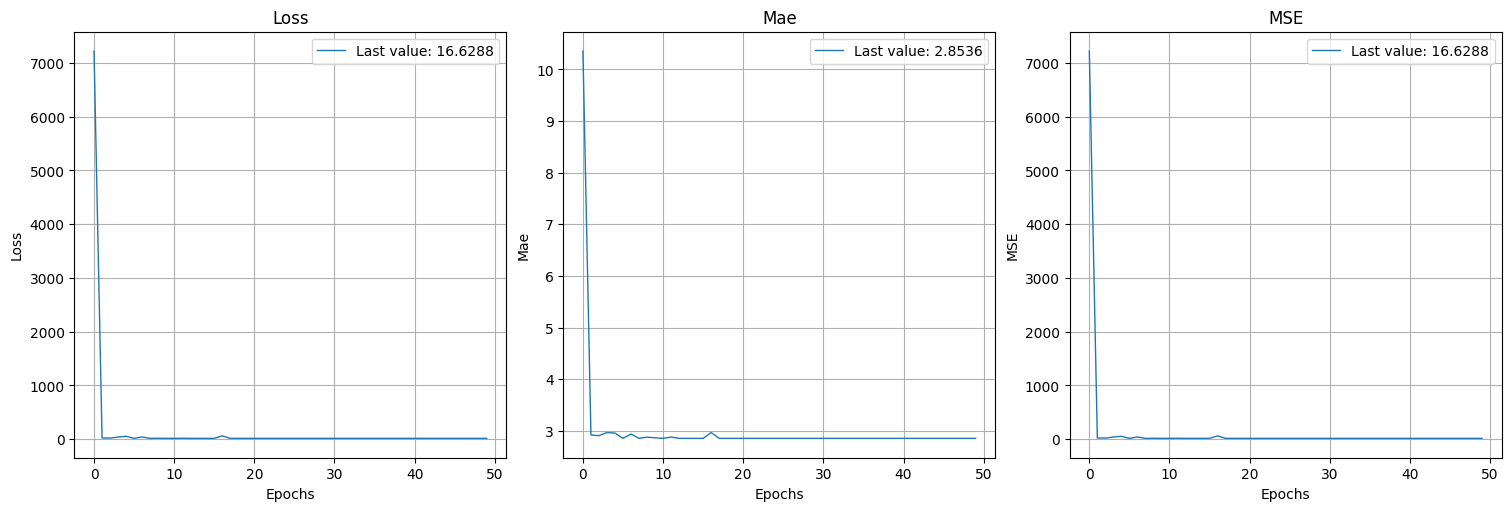

In [664]:
history = model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=True)
results = model.evaluate(x_test, y_test)
print(results)
plot_history(history.history)
plt.show()

In [665]:
# get player fixtures
id = 318
url = f"https://fantasy.premierleague.com/api/element-summary/{id}/"
r = requests.get(url).json()
fix = pd.json_normalize(r['fixtures'])
fix    

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty
0,167,2292976,11,None,13,None,17,False,0,False,2022-12-28T20:00:00Z,Gameweek 17,False,2
1,175,2292984,13,None,8,None,18,False,0,False,2022-12-31T15:00:00Z,Gameweek 18,True,2
2,184,2292993,6,None,13,None,19,False,0,False,2023-01-05T20:00:00Z,Gameweek 19,False,4
3,196,2293005,14,None,13,None,20,False,0,False,2023-01-14T12:30:00Z,Gameweek 20,False,4
4,68,2292877,13,None,18,None,20,False,0,False,2023-01-19T20:00:00Z,Gameweek 20,True,3
5,208,2293017,13,None,20,None,21,False,0,False,2023-01-22T14:00:00Z,Gameweek 21,True,2
6,219,2293028,18,None,13,None,22,False,0,False,2023-02-05T16:30:00Z,Gameweek 22,False,4
7,228,2293037,13,None,2,None,23,False,0,False,2023-02-12T16:30:00Z,Gameweek 23,True,2
8,111,2292921,1,None,13,None,23,False,0,False,2023-02-15T19:30:00Z,Gameweek 23,False,4
9,238,2293047,16,None,13,None,24,False,0,False,2023-02-18T15:00:00Z,Gameweek 24,False,2


In [ ]:
model.predict()

# predict models 


In [ ]:
# multilayer perceptron

inputLayer = Input((4,), dtype='float32')
dense = Dense(5)(inputLayer)
normal = BatchNormalization()(dense)
dense2 = Dense(5)(normal)
normal2 = BatchNormalization()(dense2)
outputLayer = Dense(3, activation='softmax')(normal2)

model_sm = Model(inputs=[inputLayer], outputs=[outputLayer])
model = Model(inputs=[inputLayer], outputs=[outputLayer])

model_sm.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')
# model.summary()

print("Model Trained with SMOTE")
history_sm = model_sm.fit(x_train_sm, y_train_sm, epochs=50, batch_size=16, verbose=False, validation_data=(x_val_sm, y_val_sm))
results_sm = model_sm.evaluate(x_test_sm, y_test_sm)
print(results_sm)
plot_history(history_sm.history)
plt.show()

print("Model Trained without SMOTE")
history = model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=False, class_weight=d_class_weights, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
print(results)
plot_history(history.history)
plt.show()